<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

# 3. Optimizations

Currently, the model is experiencing the [checkerboard problem](https://distill.pub/2016/deconv-checkerboard/). 
<br/>
<center><img src="images/shoe_maybe.png" /></center>
<br/>
Thankfully, we have a few tricks up our generated T-shirt sleeve to resolve this and generally improve the performance of the model.
<br/>
<br/>

#### Learning Objectives

The goals of this notebook are to:
* Implement Group Normalization
* Implement GELU
* Implement Rearrange Pooling
* Implement Sinusoidal Position Embeddings
* Define a reverse diffusion function to emulate `p`
* Attempt to generate articles of clothing (again)

Like before, let's use fashionMIST to experiment:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam

# Visualization tools
import matplotlib.pyplot as plt
from torchview import draw_graph
import graphviz
from IPython.display import Image

# User defined libraries
from utils import other_utils
from utils import ddpm_utils

IMG_SIZE = 16
IMG_CH = 1
BATCH_SIZE = 128
data, dataloader = other_utils.load_transformed_fashionMNIST(IMG_SIZE, BATCH_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We have created a [ddpm_util.py](utils/ddpm_utils.py) with a `DDPM` class to group our diffusion functions. Let's use it to set up the same Beta schedule as what we used previously.

In [2]:
nrows = 10
ncols = 15

T = nrows * ncols
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
ddpm = ddpm_utils.DDPM(B, device)

## 3.1 Group Normalization and GELU

The first improvement we will look at is optimizing our standard convolution process. We will be reusing this block many times throughout our neural network, so it is an important piece to get right.

### 3.1.1 Group Normalization

[Batch Normalization](https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338) converts the output of each kernel channel to a [z-score](https://www.nlm.nih.gov/oet/ed/stats/02-910.html). It does this by calculating the mean and standard deviation across a batch of inputs. This is ineffective if the batch size is small.

On the other hand, [Group Normalization](https://arxiv.org/pdf/1803.08494.pdf) normalizes the output of a group of kernels for each sample image, effectively "grouping" a set of features.

<center><img src="images/groupnorm.png" /></center>

Considering color images have multiple color channels, this can have an interesting impact on the output colors of generated images. Try experimenting to see the effect!

Learn more about normalization techniques in this [blog post](https://medium.com/techspace-usict/normalization-techniques-in-deep-neural-networks-9121bf100d8) by Aakash Bindal.

### 3.1.2 GELU

[ReLU](https://www.kaggle.com/code/dansbecker/rectified-linear-units-relu-in-deep-learning) is a popular choice for an activation function because it is computationally quick and easy to calculate the gradient for. Unfortunately, it isn't perfect. When the bias term becomes largely negative, a ReLU neuron ["dies"](https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks) because both its output and gradient are zero.

At a slight cost in computational power, [GELU](https://arxiv.org/pdf/1606.08415.pdf) seeks to rectify the rectified linear unit by mimicking the shape of the ReLU function while avoiding a zero gradient.

In this small example with FashionMNIST, it is unlikely we will see any dead neurons. However, the larger a model gets, the more likely it can face the dying ReLU phenomenon.

In [3]:
class GELUConvBlock(nn.Module):
    def __init__(
        self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## 3.2 Rearrange pooling

In the previous notebook, we used [Max Pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) to halve the size of our latent image, but is that the best technique? There are [many types of pooling layers](https://pytorch.org/docs/stable/nn.html#pooling-layers) including Min Pooling and Average Pooling. How about we let the neural network decide what is important.

Enter the [einops](https://einops.rocks/1-einops-basics/) library and the [Rearrange](https://einops.rocks/api/rearrange/) layer. We can assign each layer a variable and use that to rearrange our values. Additionally, we can use parentheses `()` to identify a set of variables that are multiplied together.

For example, in the code block below, we have:

`Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)`

* `b` is our batch dimension
* `c` is our channel dimension
* `h` is our height dimension
* `w` is our width dimension

We also have a `p1` and `p2` value that are both equal to `2`. The left portion of the equation before the arrow is saying "split the height and width dimensions in half. The right portion of the equation after the arrow is saying "stack the split dimensions along the channel dimension".

The code block below sets up a `test_image` to practice on. Try swapping `h` with `p1` on the left side of the arrow. What happens? How about when `w` and `p2` are swapped? What happens when `p1` is set to `3` instead of `2`?

In [4]:
from einops.layers.torch import Rearrange

rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)

test_image = [
    [
        [
            [1, 2, 3, 4, 5, 6],
            [7, 8, 9, 10, 11, 12],
            [13, 14, 15, 16, 17, 18],
            [19, 20, 21, 22, 23, 24],
            [25, 26, 27, 28, 29, 30],
            [31, 32, 33, 34, 35, 36],
        ]
    ]
]
test_image = torch.tensor(test_image)
print(test_image)
output = rearrange(test_image)
output

tensor([[[[ 1,  2,  3,  4,  5,  6],
          [ 7,  8,  9, 10, 11, 12],
          [13, 14, 15, 16, 17, 18],
          [19, 20, 21, 22, 23, 24],
          [25, 26, 27, 28, 29, 30],
          [31, 32, 33, 34, 35, 36]]]])


tensor([[[[ 1,  3,  5],
          [13, 15, 17],
          [25, 27, 29]],

         [[ 2,  4,  6],
          [14, 16, 18],
          [26, 28, 30]],

         [[ 7,  9, 11],
          [19, 21, 23],
          [31, 33, 35]],

         [[ 8, 10, 12],
          [20, 22, 24],
          [32, 34, 36]]]])

In [5]:
rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=3, p2=2)

test_image = [
    [
        [
            [1, 2, 3, 4, 5, 6],
            [7, 8, 9, 10, 11, 12],
            [13, 14, 15, 16, 17, 18],
            [19, 20, 21, 22, 23, 24],
            [25, 26, 27, 28, 29, 30],
            [31, 32, 33, 34, 35, 36],
        ]
    ]
]
test_image = torch.tensor(test_image)
print(test_image)
output = rearrange(test_image)
output

tensor([[[[ 1,  2,  3,  4,  5,  6],
          [ 7,  8,  9, 10, 11, 12],
          [13, 14, 15, 16, 17, 18],
          [19, 20, 21, 22, 23, 24],
          [25, 26, 27, 28, 29, 30],
          [31, 32, 33, 34, 35, 36]]]])


tensor([[[[ 1,  3,  5],
          [19, 21, 23]],

         [[ 2,  4,  6],
          [20, 22, 24]],

         [[ 7,  9, 11],
          [25, 27, 29]],

         [[ 8, 10, 12],
          [26, 28, 30]],

         [[13, 15, 17],
          [31, 33, 35]],

         [[14, 16, 18],
          [32, 34, 36]]]])

Next, we can pass this through our `GELUConvBlock` to let the neural network decide how it wants to weigh the values within our "pool". Notice the `4*in_chs` as a parameter of the `GELUConvBlock`? This is because the channel dimension is now p1 * p2 larger.

In [6]:
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

We now have the components to redefine our `DownBlock`s and `UpBlock`s. Multiple `GELUConvBlock`s have been added to help combat the checkerboard problem.

In [7]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

**TODO**: There's an input to the `UpBlock` that makes separates it from the `DownBlock`. What was it again?

If needed, click the `...` below for the correct answer.

In [8]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [ ]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

## 3.3 Time Embeddings

The better the model understands the timestep it is in for the reverse diffusion process, the better it will be able to correctly identify the added noise. In the previous notebook, we created an embedding for `t/T`. Can we help the model interpret this better?

Before diffusion models, this was a problem that plagued natural language processing. For long dialogues, how can we capture where we are? The goal was to find a way to uniquely represent a large range of discrete numbers with a small number of continuous numbers. Using a single float is ineffective since the neural network will interpret timesteps as continuous rather than discrete. [Researchers](https://arxiv.org/pdf/1706.03762.pdf) ultimately settled on a sum of sines and cosines.

For an excellent explanation for why this works and how this technique was likely developed, please refer to Jonathan Kernes' [Master Positional Encoding](https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3).

In [9]:
import math

class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

**TODO**: We will feed the output of the `SinusoidalPositionEmbedBlock` into our `EmbedBlock`. Thankfully, our `EmbedBlock` remains unchanged from before.

It looks like the one below has been overrun with `FIXME`s. Can you remember how it was supposed to look?

If needed, click the `...` below for the correct answer.

In [10]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [ ]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

## 3.4 Residual Connections

The last trick to eliminate the checkerboard problem is to add more residual or skip connections. We can create a `ResidualConvBlock` for our initial convolution. We could add residual connections in other places as well, such as within our "DownBlocks" and "UpBlocks".

In [11]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

Below is the updated model. Notice the change at the very last line? Another skip connection has been added from the output of our `ResidualConvBlock` to the final `self.out` block. This connection is surprisingly powerful, and of all the changes listed above, had the biggest influence on the checkerboard problem for this dataset.

**TODO**: A couple of new variables have been added: `small_group_size` and `big_group_size` for group normalization. They are both dependent on the variable `group_base_size`. Set `group_base_size` to either `3`, `4`, `5`, `6`, or `7`. One of these values is correct and the rest will result in an error.

**Hint**: The group sizes and `down_chs` are related.

If needed, click the `...` below for the correct answer.

In [14]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (64, 64, 128)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_dim = 8
        group_size_base = 4 # group sizes and down_chs are related. 64 // 4
        small_group_size = 2 * group_size_base  # New
        big_group_size = 8 * group_size_base  # New
        

        # Inital convolution
        self.down0 = ResidualConvBlock(img_chs, down_chs[0], small_group_size) # New

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size) # New
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size) # New
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )

        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_dim) # New
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size) # New
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size) # New
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size) # New

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]), # New
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)
        
        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t) # New
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0+temb_1, down2)
        up2 = self.up2(up1+temb_2, down1)
        return self.out(torch.cat((up2, down0), 1)) # New

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (64, 64, 128)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_dim = 8
        group_size_base = 4
        small_group_size = 2 * group_size_base # New
        big_group_size = 8 * group_size_base  # New
        

        # Inital convolution
        self.down0 = ResidualConvBlock(img_chs, down_chs[0], small_group_size) # New

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size) # New
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size) # New
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )

        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_dim) # New
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size) # New
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size) # New
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size) # New

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]), # New
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)
        
        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t) # New
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0+temb_1, down2)
        up2 = self.up2(up1+temb_2, down1)
        return self.out(torch.cat((up2, down0), 1)) # New

In [15]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(model.to(device))

Num params:  1979777


Finally, it's time to train the model. Let's see if all these changes made a difference.

Epoch 0 | step 000 Loss: 1.0223543643951416 


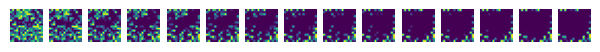

Epoch 0 | step 100 Loss: 0.21470865607261658 


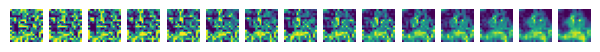

Epoch 0 | step 200 Loss: 0.13693886995315552 


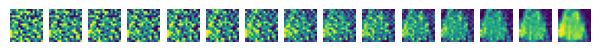

Epoch 0 | step 300 Loss: 0.13872763514518738 


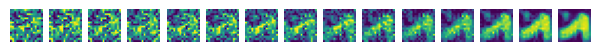

Epoch 0 | step 400 Loss: 0.13493049144744873 


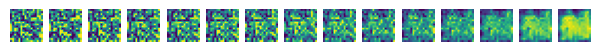

Epoch 0 | step 500 Loss: 0.11099940538406372 


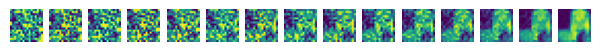

Epoch 1 | step 000 Loss: 0.10111856460571289 


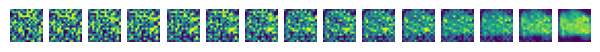

Epoch 1 | step 100 Loss: 0.11954682320356369 


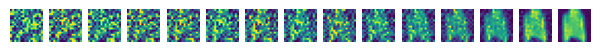

Epoch 1 | step 200 Loss: 0.11931583285331726 


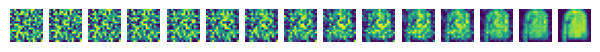

Epoch 1 | step 300 Loss: 0.10900532454252243 


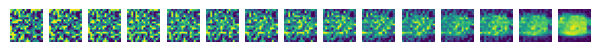

Epoch 1 | step 400 Loss: 0.12224611639976501 


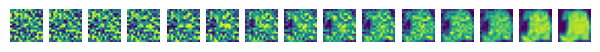

Epoch 1 | step 500 Loss: 0.10510536283254623 


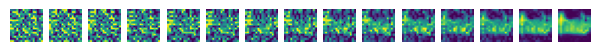

Epoch 2 | step 000 Loss: 0.10887526720762253 


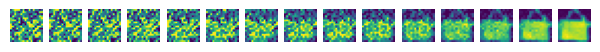

Epoch 2 | step 100 Loss: 0.09227269887924194 


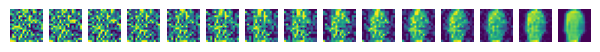

Epoch 2 | step 200 Loss: 0.10246419906616211 


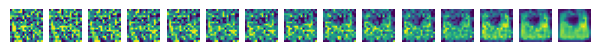

Epoch 2 | step 300 Loss: 0.10003415495157242 


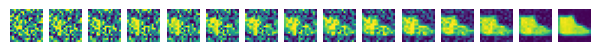

Epoch 2 | step 400 Loss: 0.08552926778793335 


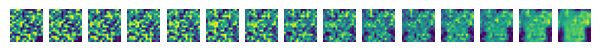

Epoch 2 | step 500 Loss: 0.07370991259813309 


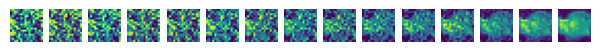

Epoch 3 | step 000 Loss: 0.09763067960739136 


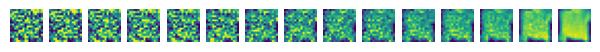

Epoch 3 | step 100 Loss: 0.09866093844175339 


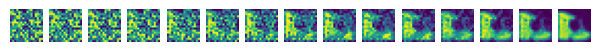

Epoch 3 | step 200 Loss: 0.09117200970649719 


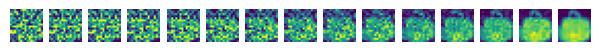

Epoch 3 | step 300 Loss: 0.0990850180387497 


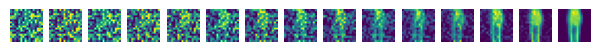

Epoch 3 | step 400 Loss: 0.09496092051267624 


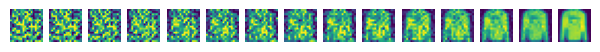

Epoch 3 | step 500 Loss: 0.10077416896820068 


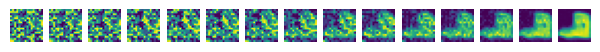

Epoch 4 | step 000 Loss: 0.07629518210887909 


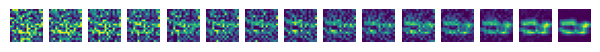

Epoch 4 | step 100 Loss: 0.09123659878969193 


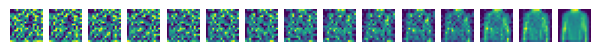

Epoch 4 | step 200 Loss: 0.08990789949893951 


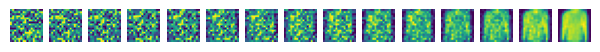

Epoch 4 | step 300 Loss: 0.09833919256925583 


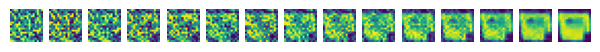

Epoch 4 | step 400 Loss: 0.09836994111537933 


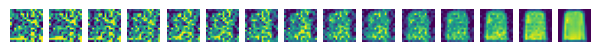

Epoch 4 | step 500 Loss: 0.08862383663654327 


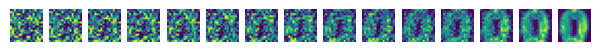

In [16]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 5

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x = batch[0].to(device)
        loss = ddpm.get_loss(model, x, t)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols)

How about a closer look? Can you recognize a shoe, a purse, or a shirt?

<Figure size 800x800 with 0 Axes>

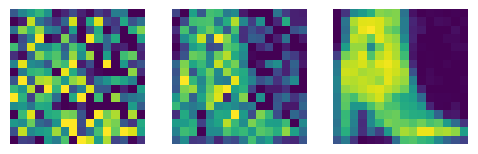

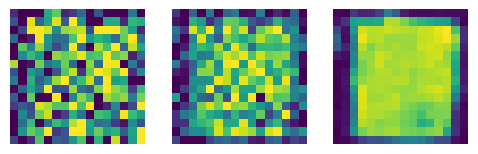

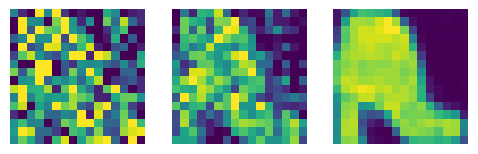

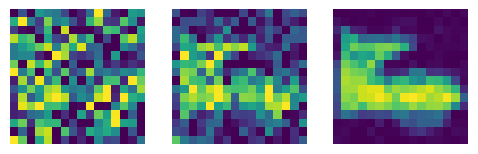

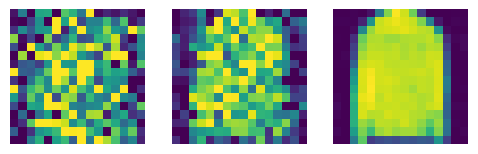

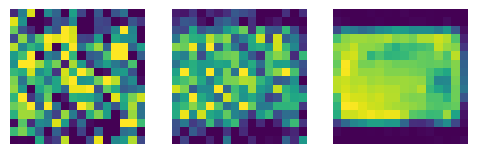

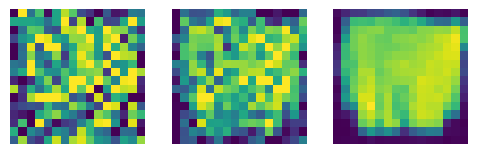

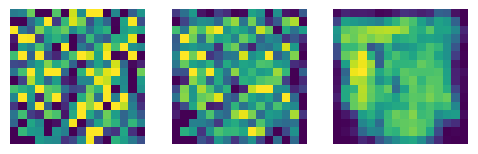

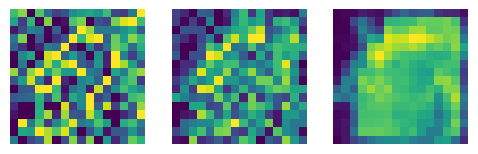

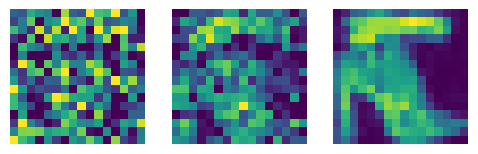

In [17]:
model.eval()
plt.figure(figsize=(8,8))
ncols = 3 # Should evenly divide T
for _ in range(10):
    ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols)

## 3.5 Next

If you don't see a particular class such as a shoe or a shirt, try running the above code block again. Currently, our model does not accept category input, so the user can't define what kind of output they would like. Where's the fun in that?

In the next notebook, we will finally add a way for users to control the model!

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>